In [ ]:
import numpy as np
import os
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from CycVoxSKPD.cs_skpd_dataset import CS_SKPDDataSet
from CycVoxSKPD.classifier_optimize_spatialShift import SKPD_LogisticRegressor_Cyclic
import seaborn as sns
from PIL import Image
import k3d
from k3d.colormaps import matplotlib_color_maps
from scipy.ndimage import zoom
import math

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def fun_normalization(data):
    data = np.abs(data)
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# Simulation 2D Example

In [114]:
shapes = ['butterfly']
shape_files = [f"data/{shape.lower()}.npy" for shape in shapes]
shape_signals = [np.array(np.load(file)) for file in shape_files]
for i, shape_array in enumerate(shape_signals):
    print(f"{shapes[i]} shape: {shape_array.shape}")

# Dataset parameters
img_shape_m, img_shape_n, img_shape_d = 128, 128, 1
N = 1000
N1 = 500
N2 = N - N1
noise_levels = [5.0] # 5.0, 10.0
np.random.seed(539)

# Generate datasets
datasets = {}
for i, (shape, C_true) in enumerate(zip(shapes, shape_signals)):
    for sigma in noise_levels:
        X = []
        Y_log = []
        epsilon = np.random.normal(0, 0.1, N) * sigma 
        for _ in trange(N1, desc=f"Generating signal + noise for {shape}, sigma={sigma}"):
            noise = np.random.normal(0, sigma, img_shape_m * img_shape_n * img_shape_d).reshape(img_shape_m, img_shape_n, img_shape_d).squeeze()
            Xi = C_true + noise
            y_reg = np.vdot(Xi.flatten(), C_true.flatten()) + epsilon[_]
            prob = 1 / (1 + np.exp(-y_reg)) 
            Y_log.append(1)
            # Y_log.append(1 if prob > 0.5 else 0)
            X.append(Xi)
        for _ in trange(N2, desc=f"Generating noise-only for {shape}, sigma={sigma}"):
            noise = np.random.normal(0, sigma, img_shape_m * img_shape_n * img_shape_d).reshape(img_shape_m, img_shape_n, img_shape_d).squeeze()
            Xi = noise
            y_reg = np.vdot(Xi.flatten(), C_true.flatten()) + epsilon[N1 + _]
            prob = 1 / (1 + np.exp(-y_reg))
            Y_log.append(0)
            # Y_log.append(0 if prob < 0.5 else 1) 
            X.append(Xi)
        X = np.array(X)
        Y_log = np.array(Y_log)
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42, shuffle=True)
        datasets[(shape, sigma)] = (C_true, X_train, X_test, Y_train, Y_test)
        print(f"Generated dataset for {shape} with sigma={sigma}, X_train shape: {X_train.shape}, Y_train: {np.bincount(Y_train)}")

butterfly shape: (128, 128)


Generating signal + noise for butterfly, sigma=5.0: 100%|██████████| 500/500 [00:00<00:00, 1916.36it/s]
Generating noise-only for butterfly, sigma=5.0: 100%|██████████| 500/500 [00:00<00:00, 2162.82it/s]

Generated dataset for butterfly with sigma=5.0, X_train shape: (800, 128, 128), Y_train: [396 404]


In [115]:
hparams_2d = {
    'p1': 32, 'p2': 32, 'p3': 1,
    'd1': 4, 'd2': 4, 'd3': 1,
    'term': 1,
    'lmbda_a': 0.1,
    'lmbda_b': 0.05,
    'lmbda_gamma': 0.0,
    'alpha': 0.2,
    'normalization_A': True,
    'normalization_B': False,
    'max_iter': 100,
    'use_cyclic': True
}



In [ ]:
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for (shape, sigma), (C_true, X_train, X_test, Y_train, Y_test) in datasets.items():
    print(f"\n=== Shape: {shape}, Sigma: {sigma} ===")
    signal_variance = np.var(C_true)
    noise_variance = sigma ** 2

    fold_accuracies = []
    fold_aucs = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]
        
        Ds_train = CS_SKPDDataSet(hparams_2d, X_train_fold, Y_train_fold, Z=None)
        Ds_val = CS_SKPDDataSet(hparams_2d, X_val_fold, Y_val_fold, Z=None)
        
        model = SKPD_LogisticRegressor_Cyclic(hparams_2d, Ds=Ds_train, max_iter=hparams_2d['max_iter'])
        A1, A2, B1, B2, gamma, C_est, train_loss = model.fit()
        C_est = fun_normalization(C_est)
        
        p_hat_val = model.predict_proba(Ds_val.X, Ds_val.X2)
        val_acc = accuracy_score(Y_val_fold, p_hat_val > 0.5)
        val_auc = roc_auc_score(Y_val_fold, p_hat_val)
        
        fold_accuracies.append(val_acc)
        fold_aucs.append(val_auc)
    
    mean_acc = np.mean(fold_accuracies)
    mean_auc = np.mean(fold_aucs)
    std_acc = np.std(fold_accuracies)
    std_auc = np.std(fold_aucs)

    results.append({
        'shape': shape,
        'sigma': sigma,
        'mean_acc': mean_acc,
        'std_acc': std_acc,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'C_est': C_est,
        'C_true': C_true
    })
    print(f"Mean Val Acc={mean_acc:.4f} ± {std_acc:.4f}, Mean Val AUC={mean_auc:.4f} ± {std_auc:.4f}")

In [117]:
print(f"Mean Val Acc={mean_acc:.4f} ± {std_acc:.4f}, Mean Val AUC={mean_auc:.4f} ± {std_auc:.4f}")

Mean Val Acc=0.9900 ± 0.0085, Mean Val AUC=0.9996 ± 0.0004


## Plot estimated coefficient

In [113]:
for res in results:
    C_true = res['C_true']
    C_est = res['C_est']

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(C_true, cmap='gray')
    axs[0].set_title("True signal")
    axs[0].axis('off')

    im = axs[1].imshow(C_est, cmap='hot')
    axs[1].set_title(f"Estimated Coefficient\nMean Accuracy: {res['mean_acc']:.3f}, Mean AUC: {res['mean_auc']:.3f}")
    axs[1].axis('off')

    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    plt.suptitle(f"Shape: {res['shape']}, σ={res['sigma']}")
    plt.tight_layout()
    plt.show()


# Simulation 3D Example

In [93]:
C_two_ball = np.load("data/2-balls.npy") 
np.random.seed(539)
img_shape_m, img_shape_n, img_shape_d = C_two_ball.shape
N = 1000
sigma = 3  # Noise level

# Define two classes
C_one_ball = np.copy(C_two_ball)
C_one_ball[:img_shape_m // 2, :, :] = 0 
N1 = 500

X = []
Y_log = []
for i in trange(N):
    Xi = np.random.normal(0, 1.0, img_shape_m * img_shape_n * img_shape_d).reshape(img_shape_m, img_shape_n, img_shape_d)
    if i < N1:
        Xi = Xi + C_two_ball  # Class 1: Two balls
        Y_log.append(1)
    else:
        Xi = Xi + C_one_ball  # Class 0: One ball
        Y_log.append(0)
    X.append(Xi)
    del Xi

X = np.array(X)
Y_log = np.array(Y_log)
# simulate z data if needed
# p = 10  # Num of covariates
# Z = np.zeros((N, p))

# # Highly correlated columns (0 and 1)
# for i in range(N):
#     if Y_log[i] == 1:
#         Z[i, 0] = np.random.normal(2, 0.5) 
#         Z[i, 1] = np.random.normal(1.5, 0.4)
#     else:
#         Z[i, 0] = np.random.normal(0, 0.5)
#         Z[i, 1] = np.random.normal(-0.5, 0.4)

# # Uncorrelated columns (2-9)
# Z[:, 2:] = np.random.normal(0, 1, (N, p-2))  # Random noise

# from scipy.stats import pearsonr
# for j in range(p):
#     corr, _ = pearsonr(Z[:, j], Y_log)
#     print(f"Z column {j+1} correlation with Y_log: {corr:.3f}")

100%|██████████| 1000/1000 [00:00<00:00, 1932.39it/s]


In [ ]:
hparams_log = dict(
    p1=8, p2=8, p3=8,
    d1=4, d2=4, d3=4,
    term=3,
    lmbda_A= 0.8,
    lmbda_B= 0.1,
    normalization_A= True,
    normalization_B = False)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)
Ds_train = CS_SKPDDataSet(hparams_log, X_train, Y_train)
Ds_test = CS_SKPDDataSet(hparams_log, X_test, Y_test)

model_log_train_balls = model = SKPD_LogisticRegressor_Cyclic(hparams_log, Ds=Ds_train)
A1, A2, B1, B2, gamma, C_est, train_loss = model.fit()
C_normal = fun_normalization(C_est)

In [98]:
p_hat_val = model.predict_proba(Ds_test.X, Ds_test.X2)
val_acc = accuracy_score(Y_test, p_hat_val > 0.5)
val_auc = roc_auc_score(Y_test, p_hat_val)
print(val_acc)
print(val_auc)

1.0
1.0


## Plot the estimated coffecient

In [97]:
plot = k3d.plot(name='plot')
plot += k3d.volume(np.where(C_est > 0.1, C_est, 0) )
plot.display()

Output()

# OASIS1 MRI

## Load dataset

In [20]:
def load_mri_images(target_folder):
    nii_files = [f for f in os.listdir(target_folder) if f.endswith('.nii')]
    mri_data_dict = {}
    expected_shape = None
    
    print(f"Total number of .nii files: {len(nii_files)}")
    
    for file_name in nii_files:
        try:
            patient_id = int(file_name.split('_')[1])
        except (IndexError, ValueError):
            print(f"Warning: Could not extract patient ID from {file_name}. Skipping.")
            continue
        
        file_path = os.path.join(target_folder, file_name)
        try:
            img = nib.load(file_path)
            data = img.get_fdata()
        except Exception as e:
            print(f"Warning: Failed to load {file_name}: {e}. Skipping.")
            continue
        
        # Check shape consistency
        if expected_shape is None:
            expected_shape = data.shape
            print(f"Dimension of the first MRI image (patient {patient_id}): {data.shape}")
        elif data.shape != expected_shape:
            print(f"Warning: Shape mismatch for patient {patient_id}. Expected {expected_shape}, got {data.shape}. Skipping.")
            continue
        
        mri_data_dict[patient_id] = data
    
    return mri_data_dict
target_folder = r'OASIS1_416_masked'
excel_path = r'oasis_adj_subjectdata.xlsx'

mri_data_dict = load_mri_images(target_folder)

Total number of .nii files: 416
Dimension of the first MRI image (patient 451): (176, 208, 176, 1)


In [21]:
def resize_volume(img, new_depth, new_height, new_width):
    img = np.squeeze(img)
    if img.ndim != 3:
        raise ValueError(f"Expected 3D tensor after squeezing, got shape {img.shape}")
    original_depth, original_height, original_width = img.shape
    depth_factor = new_depth / original_depth
    height_factor = new_height / original_height
    width_factor = new_width / original_width
    resized_img = zoom(img, (depth_factor, height_factor, width_factor), order=1)
    return resized_img

def resize_all_mri_images(mri_data_dict, new_depth, new_height, new_width):
    resized_mri_data_dict = {}

    for patient_id, img in mri_data_dict.items():
        resized_img = resize_volume(img, new_depth, new_height, new_width)
        
        resized_mri_data_dict[patient_id] = resized_img

    return resized_mri_data_dict

In [22]:
resized_mri_data_dict1 = resize_all_mri_images(mri_data_dict, 64, 64, 64)

In [23]:
meta_df = pd.read_excel(excel_path)
meta_df.head()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,0.0,1737,0.848,1.010


In [ ]:
meta_df = pd.read_excel(excel_path)
meta_df['CDR'].fillna(0, inplace=True)
meta_df['MMSE'].fillna(26, inplace=True)
meta_df['AD'] = meta_df['CDR'].apply(lambda x: 1 if x != 0 else 0)
meta_df['M/F'] = meta_df['M/F'].map({'F': 0, 'M': 1})

# Extract numeric ID and set index
meta_df['Numeric_ID'] = meta_df['ID'].str.extract(r'(\d{4})').astype(int)
meta_df.set_index('Numeric_ID', inplace=True)

# Define target
Y_log = np.array(meta_df["AD"].values)

# Define covariates
continuous_cols = ['Age', 'eTIV', 'nWBV', 'ASF']
Z_continuous = meta_df[continuous_cols].values
Z_continuous_standardized = StandardScaler().fit_transform(Z_continuous)
Z_categorical = meta_df[['M/F']].values  # Not standardized
Z_cov_standardized = np.hstack((Z_categorical, Z_continuous_standardized))

# Drop unnecessary columns
columns_to_drop = ['ID', 'Educ', 'CDR', 'MMSE', 'SES', 'AD']
meta_df.drop(columns=columns_to_drop, inplace=True)

# Align MRI data with metadata
aligned_mri_data_dict_1 = {idx: resized_mri_data_dict1[idx] for idx in meta_df.index if idx in resized_mri_data_dict1}
X_mri_1 = np.array([aligned_mri_data_dict_1[idx] for idx in meta_df.index])

# Normalize MRI data
X_mri_scaled_1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_mri_1.reshape(-1, X_mri_1.shape[-1])).reshape(X_mri_1.shape)

X = np.array(X_mri_scaled_1)
X_train, X_val, Y_train, Y_val, Z_train, Z_val = train_test_split(
    X_mri_scaled_1, Y_log, Z_cov_standardized, test_size=0.2, random_state=42, shuffle=True
)

## Train MRI 3D model

In [ ]:
hparams_best = dict(
    p1=8, p2=8, p3=8,
    d1=8, d2=8, d3=8,
    term=3,
    lmbda_a=0.1,
    lmbda_b=0.1,
    lmbda_gamma=0.5,
    alpha=0.2,
    normalization_A=True,
    normalization_B=False,
    use_cyclic=True,
    max_iter=100
)
Ds_train = CS_SKPDDataSet(hparams_best, X_train, Y_train, Z=Z_train)
Ds_val = CS_SKPDDataSet(hparams_best, X_val, Y_val, Z=Z_val)
model = SKPD_LogisticRegressor_Cyclic(hparams_best, Ds=Ds_train, max_iter=100)
A1, A2, B1, B2, gamma, C_estimate_mri, loss = model.fit()

In [53]:
p_hat_val = model.predict_proba(Ds_val.X, Ds_val.X2)
auc = roc_auc_score(Y_val, p_hat_val)
accuracy = accuracy_score(Y_val, p_hat_val > 0.5)
print(auc)
print(accuracy)

0.9076246334310851
0.8214285714285714


#### Plot out the estimted coefficient

In [54]:
plot = k3d.plot(name='plot')
plot += k3d.volume(fun_normalization(X_mri_1[1]),color_map=matplotlib_color_maps.bone_r)
plot += k3d.volume(np.where(fun_normalization(C_estimate_mri)  > 0.0, fun_normalization(C_estimate_mri) , 0) )
plot.display()

c:\Users\yuhha\anaconda3\envs\DataScience\Lib\site-packages\k3d\objects.py:1354: UserWarning: wrong dtype: float64 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


Output()

## Find most discriminative region 

In [82]:
C_estimate_abs = np.abs(C_estimate_mri)

# Axial slices (sum over x and y, vary z)
axial_scores = np.sum(C_estimate_abs, axis=(0, 1))
discriminative_axial_idx = np.argmax(axial_scores)

# Sagittal slices (sum over y and z, vary x)
sagittal_scores = np.sum(C_estimate_abs, axis=(1, 2))
discriminative_sagittal_idx = np.argmax(sagittal_scores)

# Coronal slices (sum over x and z, vary y)
coronal_scores = np.sum(C_estimate_abs, axis=(0, 2))
discriminative_coronal_idx = np.argmax(coronal_scores)

discriminative_slice_indices = {
    'axial': discriminative_axial_idx,
    'coronal': discriminative_coronal_idx,
    'sagittal': discriminative_sagittal_idx
    
}
print("Most discriminative region slice indices:", discriminative_slice_indices)

Most discriminative region slice indices: {'axial': np.int64(24), 'coronal': np.int64(32), 'sagittal': np.int64(36)}


## Find MRI slice has high auc basd on 3D trained model 

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_auc_per_slice(C_estimate, X_test, y_test, Z_test, gamma):
    """
    Compute AUC for each slice in axial, coronal, and sagittal planes and find the best slice.
    """
    # Ensure inputs are numpy arrays
    C_estimate = np.array(C_estimate)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # Z_test = np.array(Z_test)
    # gamma = np.array(gamma)

    # Get dimensions dynamically
    dim_x, dim_y, dim_z = C_estimate.shape
    n_test = X_test.shape[0]

    # Validate input shapes
    if len(C_estimate.shape) != 3:
        raise ValueError("C_estimate must be a 3D array")
    if X_test.shape != (n_test, dim_x, dim_y, dim_z):
        raise ValueError(f"X_test must have shape ({n_test}, {dim_x}, {dim_y}, {dim_z})")
    if y_test.shape != (n_test,):
        raise ValueError(f"y_test must have shape ({n_test},)")

    X_test = X_test.transpose(1, 2, 3, 0)

    # Initialize AUC arrays
    auc_axial = np.zeros(dim_z)
    auc_coronal = np.zeros(dim_y)
    auc_sagittal = np.zeros(dim_x)

    # Compute AUC for axial slices (vary z)
    for idx in range(dim_z):
        logits = X_test[:, :, idx, :].reshape(dim_x * dim_y, n_test).T @ C_estimate[:, :, idx].flatten()
        probs = 1 / (1 + np.exp(-np.clip(logits, -50, 50)))
        auc_axial[idx] = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
        if auc_axial[idx] < 0.5:
            auc_axial[idx] = 1 - auc_axial[idx]

    # Compute AUC for coronal slices (vary y)
    for idx in range(dim_y):
        logits = X_test[:, idx, :, :].transpose(1, 0, 2).reshape(dim_x * dim_z, n_test).T @ C_estimate[:, idx, :].flatten()
        probs = 1 / (1 + np.exp(-np.clip(logits, -50, 50)))
        auc_coronal[idx] = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
        if auc_coronal[idx] < 0.5:
            auc_coronal[idx] = 1 - auc_coronal[idx]

    # Compute AUC for sagittal slices (vary x)
    for idx in range(dim_x):
        logits = X_test[idx, :, :, :].reshape(dim_y * dim_z, n_test).T @ C_estimate[idx, :, :].flatten()
        probs = 1 / (1 + np.exp(-np.clip(logits, -50, 50)))
        auc_sagittal[idx] = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
        if auc_sagittal[idx] < 0.5:
            auc_sagittal[idx] = 1 - auc_sagittal[idx]

    # Find best slice (highest AUC) in range
    slice_range = slice(14, 55)
    best_slices = {
        'axial': np.argmax(auc_axial[slice_range]) + 14,
        'coronal': np.argmax(auc_coronal[slice_range]) + 14,
        'sagittal': np.argmax(auc_sagittal[slice_range]) + 14
    }
    best_aucs = {
        'axial': auc_axial[best_slices['axial']],
        'coronal': auc_coronal[best_slices['coronal']],
        'sagittal': auc_sagittal[best_slices['sagittal']]
    }

    print("Best slice indices based on AUC:", best_slices)
    print("Corresponding AUC values:", best_aucs)

    return best_slices, best_aucs

In [76]:
best_slices, best_aucs = compute_auc_per_slice(C_estimate_mri, X_val, Y_val, Z_val, gamma)

Best slice indices based on AUC: {'axial': np.int64(30), 'coronal': np.int64(35), 'sagittal': np.int64(34)}
Corresponding AUC values: {'axial': np.float64(0.8863636363636365), 'coronal': np.float64(0.874633431085044), 'sagittal': np.float64(0.8643695014662757)}


## Extract selected slice and more

In [80]:
def resize_volume(img, new_height, new_width):
    original_height, original_width = img.shape
    height_factor = new_height / original_height
    width_factor = new_width / original_width
    resized_img = zoom(img, (height_factor, width_factor), order=1)
    return resized_img

# Function to extract 2D slices at specified indices
def extract_slices_at_index(mri_data, axial_idx=None, sagittal_idx=None, coronal_idx=None):
    data = np.squeeze(mri_data)
    sagittal_dim, coronal_dim, axial_dim = data.shape  
    axial_slice = data[:, :, axial_idx] if axial_idx is not None else None
    sagittal_slice = data[sagittal_idx, :, :] if sagittal_idx is not None else None
    coronal_slice = data[:, coronal_idx, :] if coronal_idx is not None else None
    return axial_slice, sagittal_slice, coronal_slice

# Function to extract best slices for all subjects, aligned with meta_df.index
def extract_best_slices_original(mri_data_dict, meta_df, best_slice_indices_original, new_height=128, new_width=128):
    X_axial, X_sagittal, X_coronal = [], [], []
    aligned_ids = []
    
    for idx in meta_df.index:
        if idx not in mri_data_dict:
            continue
        data = np.squeeze(mri_data_dict[idx])
        axial_idx = best_slice_indices_original['axial']
        sagittal_idx = best_slice_indices_original['sagittal']
        coronal_idx = best_slice_indices_original['coronal']
        
        axial_slice, sagittal_slice, coronal_slice = extract_slices_at_index(
            data, axial_idx, sagittal_idx, coronal_idx
        )
        
        axial_slice_resized = resize_volume(axial_slice, new_height, new_width)
        sagittal_slice_resized = resize_volume(sagittal_slice, new_height, new_width)
        coronal_slice_resized = resize_volume(coronal_slice, new_height, new_width)
        
        X_axial.append(axial_slice_resized)
        X_sagittal.append(sagittal_slice_resized)
        X_coronal.append(coronal_slice_resized)
        aligned_ids.append(idx)
    
    X_axial = np.array(X_axial)
    X_sagittal = np.array(X_sagittal)
    X_coronal = np.array(X_coronal)
    
    aligned_indices = [meta_df.index.get_loc(idx) for idx in aligned_ids]
    Y_log_aligned = Y_log[aligned_indices]
    Z_cov_standardized_aligned = Z_cov_standardized[aligned_indices]
    
    return X_axial, X_sagittal, X_coronal, Y_log_aligned, Z_cov_standardized_aligned

First AD patient index in aligned data: 2


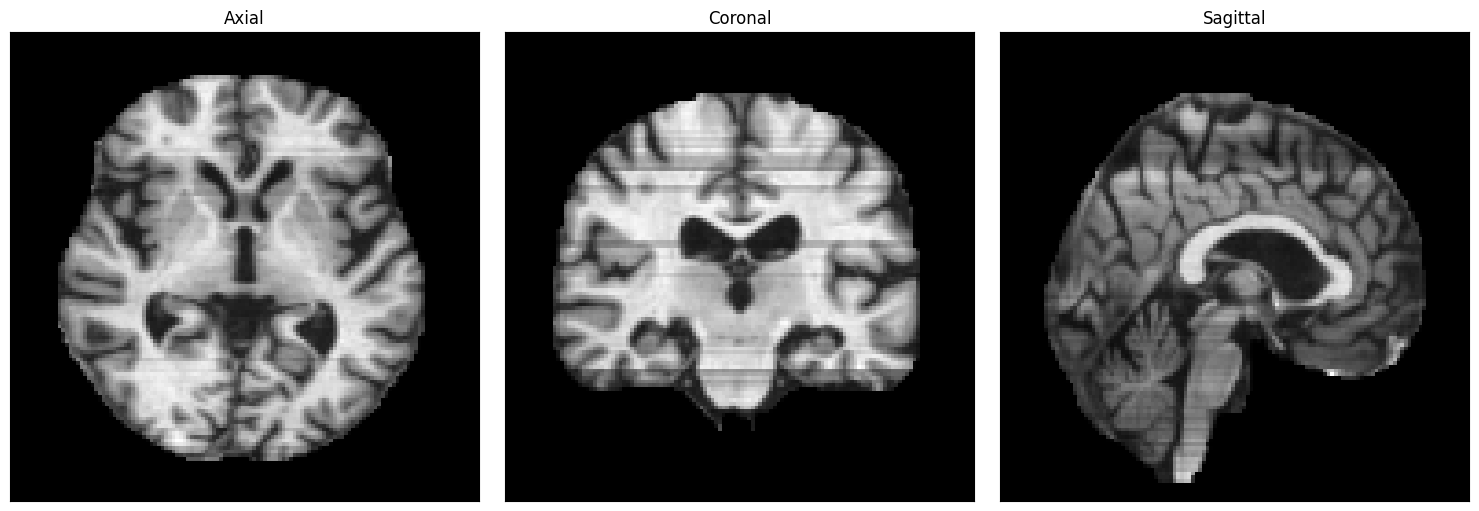

In [81]:
# Best slice indices in the original 176×208×176 dimensions
best_slice_indices_original = {'axial': 74, 'sagittal': 85, 'coronal': 98}

# Extract slices and align with metadata
X_axial, X_sagittal, X_coronal, Y_log_aligned, Z_cov_standardized_aligned = extract_best_slices_original(
    mri_data_dict, meta_df, best_slice_indices_original
)

# Normalize the slices
X_axial_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_axial.reshape(-1, X_axial.shape[-1])).reshape(X_axial.shape)
X_sagittal_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_sagittal.reshape(-1, X_sagittal.shape[-1])).reshape(X_sagittal.shape)
X_coronal_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_coronal.reshape(-1, X_coronal.shape[-1])).reshape(X_coronal.shape)

# Find the first AD patient in the aligned data
ad_indices = np.where(Y_log_aligned == 1)[0]
if len(ad_indices) == 0:
    raise ValueError("No AD patients found in Y_log_aligned")
first_ad_idx = ad_indices[0]
print(f"First AD patient index in aligned data: {first_ad_idx}")


angles_data = [
    ("Axial", X_axial_scaled),
    ("Coronal", X_coronal_scaled),
    ("Sagittal", X_sagittal_scaled)    
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (angle_name, X) in enumerate(angles_data):
    brain_slice = X[first_ad_idx]
    brain_slice = np.rot90(brain_slice, k=1)  # Rotate for better visualization
    
    ax = axes[idx]
    ax.imshow(brain_slice, cmap='gray', interpolation='nearest')
    ax.set_title(f"{angle_name}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### A = 32 x 32

In [14]:
custom_lambdas = {
    "Axial": {"lmbda_a": 0.5, "lmbda_b": 0.01},
    "Sagittal": {"lmbda_a": 0.5, "lmbda_b": 0.01},
    "Coronal": {"lmbda_a": 0.5, "lmbda_b": 0.01}
}

hparams_2d = dict(
    p1=32, p2=32, p3=1,
    d1=4, d2=4, d3=1,
    term=1,
    lmbda_a=0.4,
    lmbda_b=0.01,
    lmbda_gamma=0.0,
    alpha=0.2,
    normalization_A=True,
    normalization_B=False,
    use_cyclic=True,
    max_iter=100
)

results = []
C_estimates = {}

for angle_name, X in angles_data:
    print(f"\n=== Processing {angle_name} Slices ===")
    
    # Create a copy of hparams and update lambda values for each dataset
    hparams = hparams_2d.copy()  
    hparams["lmbda_a"] = custom_lambdas[angle_name]["lmbda_a"]
    hparams["lmbda_b"] = custom_lambdas[angle_name]["lmbda_b"]
    
    print(f"Using lambda_a = {hparams['lmbda_a']}, lambda_b = {hparams['lmbda_b']} for {angle_name}")

    # Split the data
    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
        X, Y_log_aligned, Z_cov_standardized_aligned, test_size=0.2, random_state=42, shuffle=True
    )
    
    # Prepare datasets
    Ds_train = CS_SKPDDataSet(hparams, X_train, Y_train, Z=Z_train)
    Ds_test = CS_SKPDDataSet(hparams, X_test, Y_test, Z=Z_test)
    
    # Train the model
    model = SKPD_LogisticRegressor_Cyclic(hparams, Ds=Ds_train, max_iter=100)
    A1, A2, B1, B2, gamma, C_est, train_loss = model.fit()
    
    # Evaluate on test set
    p_hat_test = model.predict_proba(Ds_test.X, Ds_test.X2)
    test_acc = accuracy_score(Y_test, p_hat_test > 0.5)
    test_auc = roc_auc_score(Y_test, p_hat_test)
    
    # Store results
    results.append({
        'angle': angle_name,
        'test_acc': test_acc,
        'test_auc': test_auc
    })
    C_estimates[angle_name] = C_est
    
    print(f"Test Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")


=== Processing Axial Slices ===
Using lambda_a = 0.5, lambda_b = 0.01 for Axial
Sample X2 largest value position after forward shift (original space 128x128): (np.int64(55), np.int64(112))

in update_B1
in update_A1
Optimization for A1 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
in update_B2
in update_A2
Optimization for A2 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Iteration 1/100, Loss: 13.635245

in update_B1
in update_A1
Optimization for A1 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
in update_B2
in update_A2
Optimization for A2 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Iteration 2/100, Loss: 7.902753

in update_B1
in update_A1
Optimization for A1 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
in update_B2
in update_A2
Optimization for A2 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Iteration 3/100, Loss: 6.827429

in update_B1
in update_A1
Optimization for A1 failed: STOP: TOTAL NO. OF F,G EVALUATIONS EX

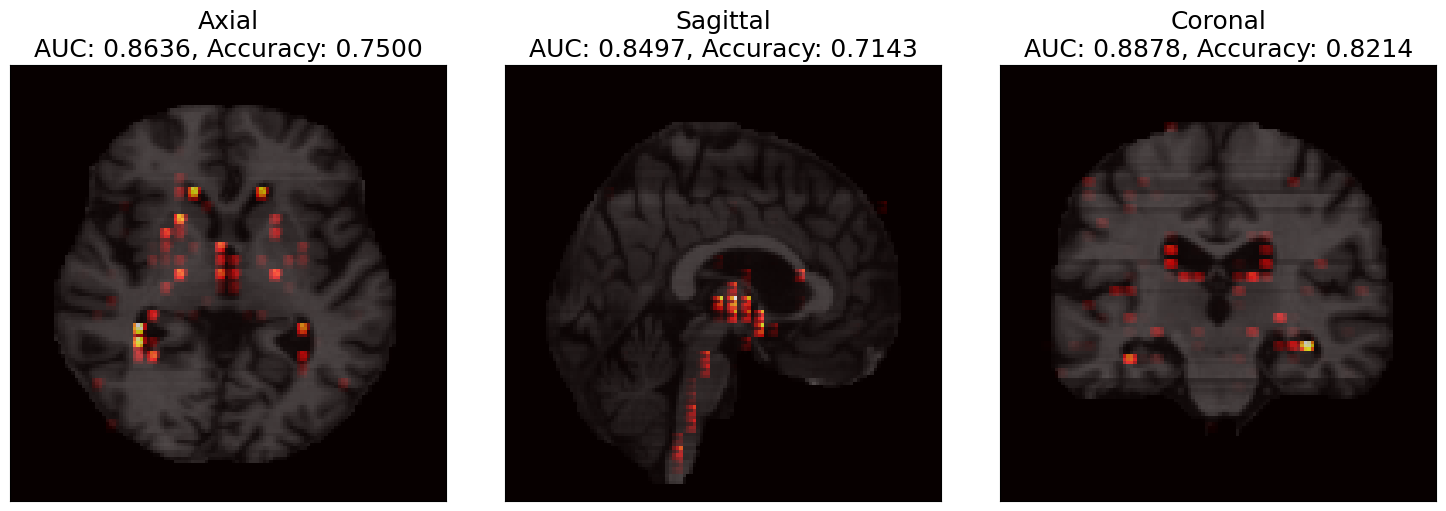

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (angle_name, X) in enumerate(angles_data):
    brain_slice = fun_normalization(X[first_ad_idx])
    brain_slice = np.rot90(brain_slice, k=1)  # Rotate
    
    C_est = fun_normalization(C_estimates[angle_name])
    C_est = np.rot90(C_est, k=1)
    
    if idx == 2:
        brain_slice = np.fliplr(brain_slice)
        C_est = np.fliplr(C_est)
        C_est = np.where(C_est  > 0.0, C_est , 0)

    ax = axes[idx]
    ax.imshow(brain_slice, cmap='gray', interpolation='nearest')
    im = ax.imshow(C_est, cmap='hot', alpha=0.72, interpolation='nearest') # jet
    
    result = next(r for r in results if r['angle'] == angle_name)
    ax.set_title(f"{angle_name}\nAUC: {result['test_auc']:.4f}, Accuracy: {result['test_acc']:.4f}", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

# plt.colorbar(im, ax=axes, label='C_estimate Intensity', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()